In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse

from datetime import date

from keras.models import Sequential,Model
from keras.layers import concatenate
from keras.layers import Dense, Flatten, Dropout
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model
from keras.layers import LSTM, GRU, Conv1D, MaxPooling1D
from keras.utils.vis_utils import plot_model
from operator import add
import json
from matplotlib.backends.backend_pdf import PdfPages

data = pd.read_csv('SP500.csv')

data.columns

data.tail()

,Date,Adj Close,Unnamed: 2,LR_SP
4520,15-03-2021,3968.939941,3.598675,-0.002810
4521,16-03-2021,3962.709961,3.597992,0.000682
4522,17-03-2021,3974.120117,3.599241,-0.001249
4523,18-03-2021,3915.459961,3.592783,0.006458
4524,19-03-2021,3913.100098,3.592521,0.000262


In [2]:
data = data.fillna(-0.005242)

In [3]:
data['Sqr_Ret'] = data['LR_SP']**2
#data = data[1:]
#data = data.reset_index()

In [4]:
data['exp_Vol'] = np.nan

In [5]:
(len(data['Sqr_Ret']))

4525

In [6]:
# data['exp_Vol'] = data['Sqr_Ret'].ewm(alpha=0.06,min_periods=66).mean()

In [7]:
lam = 0.06
n = 66
for i in range(66,(len(data['Sqr_Ret']))):
    inp = data['Sqr_Ret'].loc[i-66:i-1]
    x = inp.ewm(alpha=0.06,min_periods=66).mean()
    value = x.loc[i-1]
    data['exp_Vol'].loc[i] = value

C:\Users\kshit\Anaconda3\envs\my_env\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [8]:
# for i in range(66,(len(data['Sqr_Ret']))):
#     inp = data['Sqr_Ret'].loc[i-66:i-1]
#     x = inp.mean()
#     value = x
#     data['exp_Vol'].loc[i] = value

In [9]:
# lam = 0.94
# n = 66
# wts = [(lam**(i-1) * (1-lam))/(1-lam**n) for i in range(0, n)]
# wts.reverse()
# wts = np.array(wts).reshape(1,-1)
# wts = wts/wts.sum()
# for i in range(66,(len(data['Sqr_Ret']))):
#     inp = data['Sqr_Ret'].loc[i-66:i-1]
#     inp = inp.to_numpy().reshape(-1,1)
#     tot = np.dot(wts,inp)
#     data['exp_Vol'].loc[i] = tot.sum()

In [10]:
# data['r']=data['LR_SP']*data['LR_SP']
# data['stdev_SP']=data['r']
# for i in range(2,len(data)):
#     data['stdev_SP'].loc[i]=0.9*data['stdev_SP'].loc[i-1]+0.1*data['r'].loc[i]
# data

In [11]:
# data['stdev_SP'] = data['stdev_SP'] **0.5

# data['Volatility_SP'] = data['stdev_SP'] 
# data['Volatility_SP'] = data['Volatility_SP']*100

# data['stdev_USD'] = data['Unnamed: 3'].rolling(window=66, center=False).std()
# data['stdev_USD'] = data['stdev_USD'].dropna()
# data['Volatility_SP'] = data['stdev_USD'] 
# # data['Volatility_SP'] = data['Volatility_SP']*100
data['exp_Vol'] = data['exp_Vol']**0.5
data['Volatility_SP'] = data['exp_Vol']*100
data.dropna(inplace=True)
symbols = ['Volatility_SP']
window_sizes = [22]
data

,Date,Adj Close,Unnamed: 2,LR_SP,Sqr_Ret,exp_Vol,Volatility_SP
66,03-07-2003,985.700012,2.993745,0.003532,1.247771e-05,0.004333,0.433292
67,07-07-2003,1004.419983,3.001915,-0.008171,6.675841e-05,0.004287,0.428731
68,08-07-2003,1007.840027,3.003392,-0.001476,2.179338e-06,0.004618,0.461780
69,09-07-2003,1002.210022,3.000959,0.002433,5.918813e-06,0.004478,0.447758
70,10-07-2003,988.700012,2.995065,0.005894,3.474162e-05,0.004382,0.438201
...,...,...,...,...,...,...,...
4520,15-03-2021,3968.939941,3.598675,-0.002810,7.897747e-06,0.004802,0.480176
4521,16-03-2021,3962.709961,3.597992,0.000682,4.654528e-07,0.004707,0.470688
4522,17-03-2021,3974.120117,3.599241,-0.001249,1.559259e-06,0.004566,0.456644
4523,18-03-2021,3915.459961,3.592783,0.006458,4.170837e-05,0.004437,0.443667


In [12]:
import math as math
data1 = pd.read_csv('sgarch_66_sp500_f.csv')
data2 = pd.read_csv('sgarch_66_sp500_f.csv')

#Iterate through all the comninations of the input series manually

data1 = data1.dropna()
data2 = data2.dropna()


data1.reset_index(inplace=True)
data2.reset_index(inplace=True)


data1 = data1.drop(['index'], axis=1)
data2 = data2.drop(['index'], axis=1)


data1['x'] = data1['x'].replace([0, -np.inf], data1['x'].nsmallest(2).iloc[-1])
data2['x'] = data2['x'].replace([0, -np.inf], data2['x'].nsmallest(2).iloc[-1])


data1['x'] = data1['x'].replace([np.inf], data1['x'].nlargest(2).iloc[-1])
data2['x'] = data2['x'].replace([np.inf], data2['x'].nlargest(2).iloc[-1])

data1['x'] = data1['x'].apply(lambda x: math.sqrt(x))
data2['x'] = data2['x'].apply(lambda x: math.sqrt(x))


In [13]:
data = data.iloc[1:]

In [14]:
#x = list(range(22,67))

In [15]:
#data.drop(x,axis=0,inplace=True)

In [16]:
# data2.drop(0,axis=0,inplace=True)

In [17]:
#data1 = data1[0:-1]

In [18]:
data.tail()

,Date,Adj Close,Unnamed: 2,LR_SP,Sqr_Ret,exp_Vol,Volatility_SP
4520,15-03-2021,3968.939941,3.598675,-0.002810,7.897747e-06,0.004802,0.480176
4521,16-03-2021,3962.709961,3.597992,0.000682,4.654528e-07,0.004707,0.470688
4522,17-03-2021,3974.120117,3.599241,-0.001249,1.559259e-06,0.004566,0.456644
4523,18-03-2021,3915.459961,3.592783,0.006458,4.170837e-05,0.004437,0.443667
4524,19-03-2021,3913.100098,3.592521,0.000262,6.855495e-08,0.004588,0.458782


In [19]:
data1.tail()

,Unnamed: 0,x
4453,4454,0.068842
4454,4455,0.067448
4455,4456,0.067036
4456,4457,0.066686
4457,4458,0.067454


In [20]:
data.dropna(inplace=True)

<ipython-input-20-f1116dacf2bb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


In [21]:
data.shape

(4458, 7)

In [22]:
data1.shape

(4458, 2)

In [23]:
data1['x'] = data1['x']*10
data2['x'] = data2['x']*10

In [24]:
data1.head()

,Unnamed: 0,x
0,1,0.651108
1,2,0.658816
2,3,0.658148
3,4,0.654013
4,5,0.664615


In [25]:
data1.tail()

,Unnamed: 0,x
4453,4454,0.688423
4454,4455,0.674483
4455,4456,0.670356
4456,4457,0.666863
4457,4458,0.674545


In [26]:
data.head()

,Date,Adj Close,Unnamed: 2,LR_SP,Sqr_Ret,exp_Vol,Volatility_SP
67,07-07-2003,1004.419983,3.001915,-0.008171,0.000067,0.004287,0.428731
68,08-07-2003,1007.840027,3.003392,-0.001476,0.000002,0.004618,0.461780
69,09-07-2003,1002.210022,3.000959,0.002433,0.000006,0.004478,0.447758
70,10-07-2003,988.700012,2.995065,0.005894,0.000035,0.004382,0.438201
71,11-07-2003,998.140015,2.999191,-0.004127,0.000017,0.004491,0.449096


In [27]:
data.tail()

,Date,Adj Close,Unnamed: 2,LR_SP,Sqr_Ret,exp_Vol,Volatility_SP
4520,15-03-2021,3968.939941,3.598675,-0.002810,7.897747e-06,0.004802,0.480176
4521,16-03-2021,3962.709961,3.597992,0.000682,4.654528e-07,0.004707,0.470688
4522,17-03-2021,3974.120117,3.599241,-0.001249,1.559259e-06,0.004566,0.456644
4523,18-03-2021,3915.459961,3.592783,0.006458,4.170837e-05,0.004437,0.443667
4524,19-03-2021,3913.100098,3.592521,0.000262,6.855495e-08,0.004588,0.458782


In [28]:
def adj_r2_score(r2, n, k):
    return 1 - ((1 - r2) * ((n - 1) / (n - k - 1)))

def window_transform(time_series, window_size):
    X = []
    y = []
    for i in range(time_series.shape[0] - window_size):
        X.append(time_series[i:i + window_size])
        y.append(time_series[i + window_size])
        
    return np.array(X), np.array(y)

def window_transform1(time_series, window_size):
    X = []
    y = []
    for i in range(time_series.shape[0] - window_size):
        X.append(time_series[i+1:i + window_size+1])
        y.append(time_series[i + window_size])
        
    return np.array(X), np.array(y)
  
def make_GARCH_lstm_model(window_size):
    model_lstm = Sequential()
    model_lstm.add(LSTM(40, input_shape=(window_size, 1), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
    model_lstm.add(Dropout(0.05))
#     model_lstm.add(LSTM(128, activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
#     model_lstm.add(Dropout(0.05))
    model_lstm.add(Dense(1, activation='linear'))
    model_lstm.compile(loss='mean_squared_error', optimizer='adam')

    return model_lstm

def future_lstm_model():
    model_lstm = Sequential()
    model_lstm.add(LSTM(40, input_shape=(22, 1), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
    model_lstm.add(Dropout(0.05))
#     model_lstm.add(LSTM(128, activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
#     model_lstm.add(Dropout(0.05))
    model_lstm.add(Dense(1, activation='linear'))
    model_lstm.compile(loss='mean_squared_error', optimizer='adam')

    return model_lstm

def test_model(model, X_train, X_test, y_train, y_test):
    y_pred_test_ann = model.predict(X_test)
    y_train_pred_ann = model.predict(X_train)
    r2_train = mse(y_train, y_train_pred_ann)
    r2_test = mse(y_test, y_pred_test_ann)

    return r2_train, r2_test

def plot_all_model():
    print('plotting_model')
    ann_model = make_ann_model(3)
    cnn_model = make_cnn_model(3)
    lstm_model = make_lstm_model(3)
    gru_model = make_gru_model(3)

    plot_model(ann_model, to_file='ann_plot.png', show_shapes=True, show_layer_names=True)
    plot_model(cnn_model, to_file='cnn_plot.png', show_shapes=True, show_layer_names=True)
    plot_model(lstm_model, to_file='lstm_plot.png', show_shapes=True, show_layer_names=True)
    plot_model(gru_model, to_file='gru_plot.png', show_shapes=True, show_layer_names=True)

In [29]:
data['Date'] = pd.to_datetime(data['Date'])

<ipython-input-29-1a72a8b5b870>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'])


Epoch 1/100
109/109 [==============================] - 3s 6ms/step - loss: 0.0049
Epoch 2/100
109/109 [==============================] - 1s 5ms/step - loss: 0.0019
Epoch 3/100
109/109 [==============================] - 1s 5ms/step - loss: 0.0018
Epoch 4/100
109/109 [==============================] - 1s 5ms/step - loss: 8.7423e-04
Epoch 5/100
109/109 [==============================] - 1s 5ms/step - loss: 7.1072e-04
Epoch 6/100
109/109 [==============================] - 1s 5ms/step - loss: 8.4893e-04
Epoch 7/100
109/109 [==============================] - 1s 6ms/step - loss: 5.8196e-04
Epoch 8/100
109/109 [==============================] - 1s 7ms/step - loss: 5.3510e-04
Epoch 9/100
109/109 [==============================] - 1s 6ms/step - loss: 9.0413e-04
Epoch 10/100
109/109 [==============================] - 1s 5ms/step - loss: 5.2623e-04
Epoch 11/100
109/109 [==============================] - 1s 6ms/step - loss: 6.1822e-04
Epoch 12/100
109/109 [==============================] - 1s 6ms/s

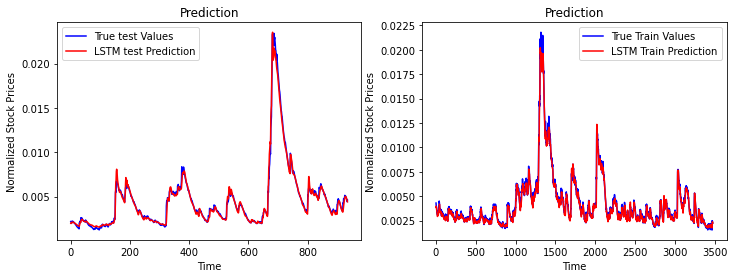

In [30]:
output=pd.DataFrame()
output_train=pd.DataFrame()
for sym in symbols:
  df = data[sym]
  df1 = data[sym]
  df.index = data['Date']
  df1.index = data['Date']
  df=pd.DataFrame(df)
  df1=pd.DataFrame(df1)
  #df['forecast_vol_Copper'] = ((data2['x'].values)) 
  df1['forecast_vol_SP500'] = ((data2['x'].values)) 
  split_date = pd.Timestamp('01-01-2017')
  split_date = 3500   
  train = df.iloc[:split_date]
  test = df.iloc[split_date:]
  train1 = df1.iloc[:split_date]
  test1 = df1.iloc[split_date:]
  sc = MinMaxScaler()
  train_sc1 = sc.fit_transform(train1)
  test_sc1 = sc.transform(test1)
  train_sc = sc.fit_transform(train)
  test_sc = sc.transform(test)

  ann = []
  gru = []
  lstm = []
  cnn = []
  GARCH_lstm = []
  output[sym + "_" + "True_test"] = pd.Series(np.reshape(test_sc[:,0], ( -1)))
  output_train[sym + "_" + "True_train"] = pd.Series(np.reshape(train_sc[:,0], ( -1)))
  for win_sz in window_sizes:
    ann_result = []
    gru_result = []
    lstm_result = []
    cnn_result = []
    lstm_GARCH_result = []
    pred_ANN = []
    pred_LSTM = []
    pred_GRU = []
    pred_CNN = []
    pred_GARCH_LSTM = []
    pred_GARCH_LSTM_train = []
    
    X_train, y_train = window_transform(train_sc, win_sz)
    X_test, y_test = window_transform(test_sc, win_sz)
    X_tr_t = X_train.reshape(X_train.shape[0], win_sz, 1)
    X_tst_t = X_test.reshape(X_test.shape[0], win_sz, 1)
    #y_train = np.delete(y_train,1,1)
    #y_test = np.delete(y_test,1,1)
    X_tr_t = X_tr_t.reshape(X_tr_t.shape[0], win_sz, 1)
    X_tst_t = X_tst_t.reshape(X_tst_t.shape[0], win_sz, 1)
        
    X_train1, y_train1 = window_transform1(train_sc1, win_sz)
    X_test1, y_test1 = window_transform1(test_sc1, win_sz)
    
    y_train1 = np.delete(y_train1,1,1)
    y_test1 = np.delete(y_test1,1,1)
    X_train1 = np.delete(X_train1,0,2)
    X_test1 = np.delete(X_test1,0,2)
    
    X_train1 = X_train1
    y_train1 = y_train1
    X_test1 = X_test1
    y_test1 = y_test1
    X_tr_t1 = X_train1.reshape(X_train1.shape[0], win_sz, 1)
    X_tst_t1 = X_test1.reshape(X_test1.shape[0], win_sz, 1)
    
    for i in range(2):

      model1 = make_GARCH_lstm_model(win_sz)
      model2 = future_lstm_model()
      
      merged = concatenate([model1.output,model2.output])
      
      z = Dense(128, activation='relu')(merged)
      z = Dropout(0.05)(z)
      z = Dense(64, activation='relu')(merged)
      z = Dropout(0.05)(z)
      z = Dense(1, activation="linear")(z)

      model = Model(inputs=[model1.input, model2.input], outputs=z)
      model.compile(loss='mean_squared_error', optimizer='adam')

      early_stop = EarlyStopping(monitor='loss', patience=6, verbose=1)
      history_model_GARCH_lstm = model.fit([X_tr_t, X_tr_t1], y_train, epochs=100, batch_size=32, verbose=1, shuffle=False,callbacks=[early_stop])
      #train_acc, test_acc = test_model(model, X_tr_t, X_tst_t, y_train, y_test)
      y_pred_test_GARCH_LSTM = model.predict([X_tst_t, X_tst_t1])
      y_pred_test_GARCH_LSTM_train = model.predict([X_tr_t, X_tr_t1])
      #lstm_GARCH_result.append(test_acc)

      #pred_LSTM.append(y_pred_test_LSTM)
      pred_GARCH_LSTM.append(y_pred_test_GARCH_LSTM)
      pred_GARCH_LSTM_train.append(y_pred_test_GARCH_LSTM_train)


    #lstm.append([win_sz, min(lstm_result), np.mean(lstm_result), np.std(lstm_result)])
    #GARCH_lstm.append([win_sz, min(lstm_GARCH_result), np.mean(lstm_GARCH_result), np.std(lstm_GARCH_result)])  

    
    plot_GARCH_lstm = [0] * len(pred_GARCH_LSTM[0])
    for pred in pred_GARCH_LSTM:
        plot_GARCH_lstm = list(map(add, plot_GARCH_lstm, pred))

    for i in range(len(plot_GARCH_lstm)):
        plot_GARCH_lstm[i] = plot_GARCH_lstm[i] / 2

    plot_GARCH_lstm_train = [0] * len(pred_GARCH_LSTM_train[0])
    for pred in pred_GARCH_LSTM_train:
        plot_GARCH_lstm_train = list(map(add, plot_GARCH_lstm_train, pred))

    for i in range(len(plot_GARCH_lstm_train)):
        plot_GARCH_lstm_train[i] = plot_GARCH_lstm_train[i] / 2

    plot_GARCH_lstm = sc.inverse_transform(plot_GARCH_lstm)
    plot_GARCH_lstm_train = sc.inverse_transform(plot_GARCH_lstm_train)
    plot_GARCH_lstm = plot_GARCH_lstm/100
    plot_GARCH_lstm_train = plot_GARCH_lstm_train/100
    y_test = sc.inverse_transform(y_test)
    y_test = y_test/100
    y_train = sc.inverse_transform(y_train)
    y_train = y_train/100
    
    output[sym + "_" + str(win_sz) + "_test_LSTM"] = pd.Series(np.reshape(plot_GARCH_lstm, (-1)))
    output_train[sym + "_" + str(win_sz) + "_train_LSTM"] = pd.Series(np.reshape(plot_GARCH_lstm_train, (-1)))
    output[sym + "_" + str(win_sz) + "_test_real_LSTM"] = pd.Series(np.reshape(y_test, (-1)))
    output_train[sym + "_" + str(win_sz) + "_train_real_LSTM"] = pd.Series(np.reshape(y_train, (-1)))

    f = plt.figure(figsize=(12,4))
    ax1 = f.add_subplot(121)
    ax2 = f.add_subplot(122)

    ax1.plot(y_test, '-', label='True test Values', color='b')
    ax1.plot(plot_GARCH_lstm, label='LSTM test Prediction', color='r')
    ax1.set_title("Prediction")
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Normalized Stock Prices')
    ax1.legend()

    ax2.plot(y_train, '-', label='True Train Values', color='b')
    ax2.plot(plot_GARCH_lstm_train, label='LSTM Train Prediction', color='r')
    ax2.set_title("Prediction")
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Normalized Stock Prices')
    ax2.legend()
#output.to_excel('output.xlsx')   
#output_train.to_excel('output_train.xlsx')   

In [31]:
plot_GARCH_lstm[0].shape

(1,)

In [32]:
train.shape

(3500, 1)

In [33]:
X_tr_t.shape

(3478, 22, 1)

In [34]:
X_tr_t1.shape

(3478, 22, 1)

In [40]:
df1 = output_train
df1.index = data['Date'].iloc[0:df1.shape[0]].values
df2 = output
df2.index = data['Date'].iloc[df1.shape[0]:(df1.shape[0]+df2.shape[0])].values

In [41]:
from IPython.display import HTML
import pandas as pd
import numpy as np
import base64
def create_download_link(df2, title = "Download CSV file", filename = "Copper_STD_test.csv"):
    csv = df2.to_csv(index=True)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)
create_download_link(df2)

In [37]:
from IPython.display import HTML
import pandas as pd
import numpy as np
import base64
def create_download_link(df1, title = "Download CSV file", filename = "Copper_S-LSTM_train.csv"):
    csv = df1.to_csv(index=True)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)
create_download_link(df1)

In [ ]:
#8 one